<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">Определение возраста человека по его фотографии</h1>

**Задача:** Построить модель, которая по фотографии определит приблизительный возраст человека.

**Цель:** Определять возраст покупателей в прикассовой зоне, чтобы делать рекомендации товаров и контролировать продажу алкоголя несовершеннолетним.

<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">1. Загрузка данных, исследовательский анализ</h1>

In [32]:
import numpy as np
import pandas as pd
from PIL import Image

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential, regularizers, callbacks, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
def load_train(path):
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split = 0.25,
        horizontal_flip = True
    )
    labels = pd.read_csv(path + 'labels.csv')
    train_flow = train_datagen.flow_from_dataframe(
        labels, 
        directory = path + 'final_files/final_files/',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
        )

    labels = pd.read_csv(path + 'labels.csv')
    test_flow = test_datagen.flow_from_dataframe(
        labels, 
        directory = path + 'final_files/final_files/',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=100,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_flow

In [3]:
path = '/kaggle/input/appa-real-face-cropped/'
train_flow = load_train(path)
test_flow = load_test(path)
labels = pd.read_csv(path + 'labels.csv')

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [4]:
display(labels.head()) 
display(labels.info())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

In [5]:
print('Размер выборки:', labels.shape)
print('пропущенных значений:')
print(labels.isna().sum())

Размер выборки: (7591, 2)
пропущенных значений:
file_name    0
real_age     0
dtype: int64


Размер фотографий в наборе данных:

In [6]:
im_size_x, im_size_y = np.array([]), np.array([])
for i in range(len(labels)):
    im = Image.open(path + 'final_files/final_files/' + labels.iloc[i, 0])
    im_size_x = np.append(im_size_x, im.size[0])
    im_size_y = np.append(im_size_y, im.size[1])

In [7]:
print('Неквадратных изображений:', np.sum( (im_size_x - im_size_y) != 0) )
not_rect = \
    ((abs(im_size_x/im_size_y) > 1.1) 
     + 
     (abs(im_size_x/im_size_y) < 0.9))

print( 'Изображения с разницей ширины и высоты более 10%:', np.sum(not_rect))
print( 'Доля таких изображений', np.sum(not_rect) / len(labels) )

Неквадратных изображений: 2191
Изображения с разницей ширины и высоты более 10%: 190
Доля таких изображений 0.02502964036358846


В основном набор данных представлен квдратными изображениями. Но небольшая доля изображений будет растянута или сжата на более чем 10% при предобработке (resizing) данных в keras.

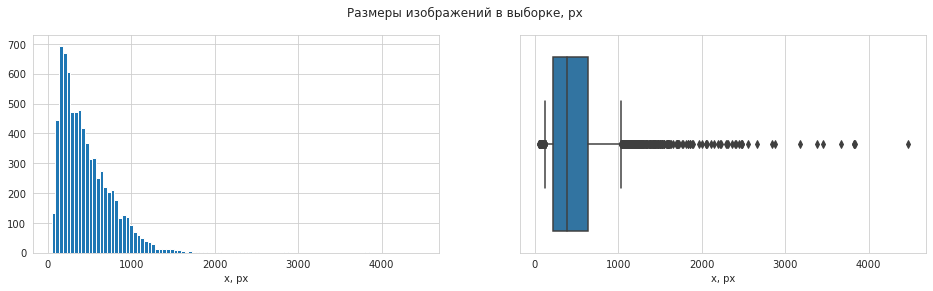

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,4))
ax1, ax2 = axs.flatten()
ax1.hist(im_size_x, bins=100)
ax1.set_xlabel('x, px')
ax2.set_xlabel('x, px')
sns.boxplot(im_size_x, whis = [5,95])
plt.suptitle('Размеры изображений в выборке, px')
plt.show()

In [9]:
print('Минимальный размер изображений по x:', im_size_x.min())
print('Средний размер изображений по x:', im_size_x.mean().round(0))
print('Медианный размер изображений по x:', np.median(im_size_x))
print('Максимальный размер изображений по x:', np.max(im_size_x))

Минимальный размер изображений по x: 47.0
Средний размер изображений по x: 465.0
Медианный размер изображений по x: 385.0
Максимальный размер изображений по x: 4466.0


In [10]:
pd.Series(im_size_x).describe()

count    7591.000000
mean      464.733764
std       330.834794
min        47.000000
25%       220.000000
50%       385.000000
75%       632.000000
max      4466.000000
dtype: float64

Размеры изображений в выборке имеют существенный разброс. 75% изображений больше 220 px по оси x. Нужно выполнять resize. Причём, растягивать большое количество изображений, наверное, нежелательно, т.к. на растянутых изображениях изначально группы пикселей несут меньше информации, чем на сжатых. Если использовать размер 224x224, растянутыми более чем в два раза окажутся:

In [11]:
print( round( 100*np.sum(im_size_x < 112) / len(labels), 1) , '% изображений')

4.2 % изображений


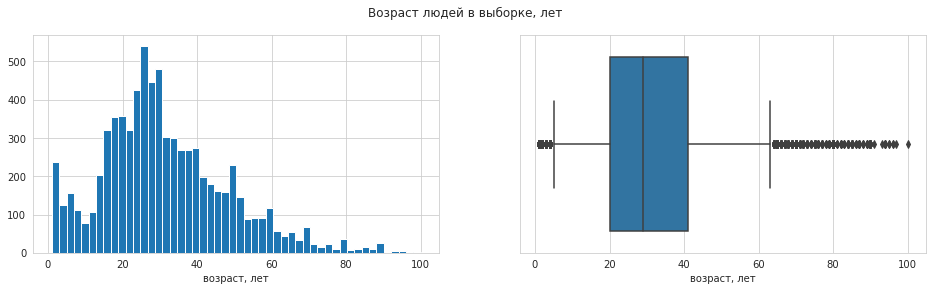

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,4))
ax1, ax2 = axs.flatten()
ax1.hist(labels.real_age, bins=50)
ax1.set_xlabel('возраст, лет')
sns.boxplot(labels.real_age, whis = [5,95])
ax2.set_xlabel('возраст, лет')
plt.suptitle('Возраст людей в выборке, лет')
plt.show()

In [13]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Люди в выборке по возрасту распределены неравномерно. Но, на мой взгляд, выборка в целом соответствует людям, посещающим магазины. Однако виден провал в "тинейджерском интервале" и с контролем продажи алкоголя подросткам могут быть проблемы:

In [14]:
print('Людей старше 13 и младше 18 лет в выборке:', sum ((labels.real_age > 13).values * (labels.real_age < 18).values))

Людей старше 13 и младше 18 лет в выборке: 609


Этого мало для хорошего обучения, на мой взгляд.

In [15]:
X, y = next(train_flow)

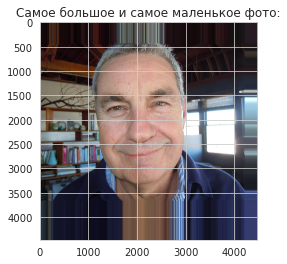

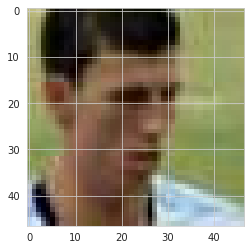

In [16]:
big_img_index = np.argsort(im_size_x)[-1]
small_img_index = np.argsort(im_size_x)[0]
img_big = Image.open(path + 'final_files/final_files/' + labels.iloc[big_img_index, 0])
img_small = Image.open(path + 'final_files/final_files/' + labels.iloc[small_img_index, 0])
plt.imshow(img_big)
plt.title('Самое большое и самое маленькое фото:')
plt.show()
plt.imshow(img_small)
plt.show()

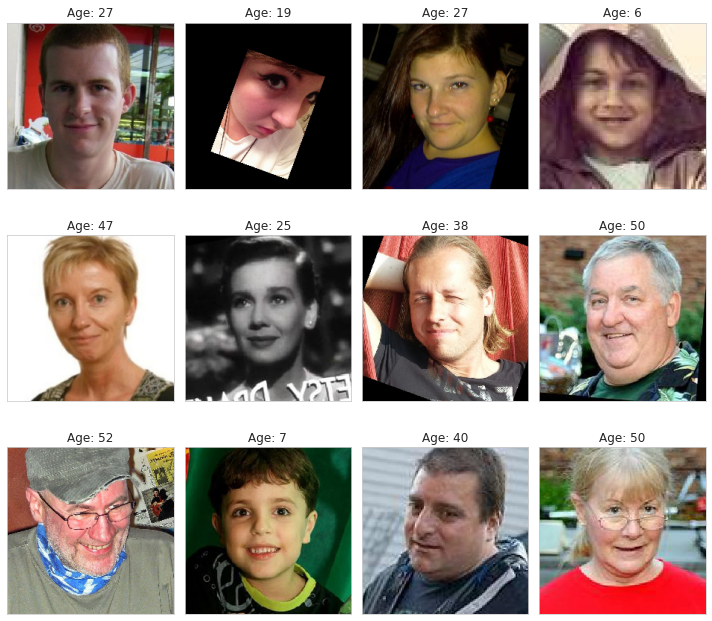

In [17]:
# выводим 12 изображений
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(X[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.title( 'Age: ' + str(y[i]) )
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">Выводы по исследовательскому анализу</h1>

В наборе данных 7591 изображений лиц, с разбросом по размерам, часть фото - неквадратные. Выборка по возрасту в целом соответствует людям, посещающим магазины, однако несбалансирована. Есть провал в "тинейджерском интервале" и с контролем продажи алкоголя подросткам могут быть проблемы.

<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">2. Обучение модели</h1>

Обучение модели с архитектурой, построенной на базе [статьи 1](https://github.com/emredogan7/age-estimation-by-CNN/blob/master/doc/report.pdf) и [статьи 2](https://talhassner.github.io/home/publication/2015_CVPR) на базе kaggle ([см. тетрадку kaggle](https://www.kaggle.com/affernus/cv-age-recognision-by-face)).

In [30]:
def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(lr=0.001)
    # 224x224x3 ->
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(7, 7), 
                     padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(BatchNormalization(momentum=0.9))

    model.add(Conv2D(filters=256, kernel_size=(5, 5), 
                     padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(BatchNormalization(momentum=0.9))

    model.add(Conv2D(filters=384, kernel_size=(3, 3), 
                     padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Flatten())

    model.add(Dropout(0.2))

    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=1, activity_regularizer = regularizers.l2(0.01), activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_flow, test_flow, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None, callbacks_list = None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_flow)
    if validation_steps is None:
        validation_steps = len(test_flow)

    model.fit(train_flow,
              validation_data=test_flow,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps, 
              epochs=epochs,
              callbacks = callbacks_list,
              verbose=2,
              shuffle=True)

    return model

In [24]:
model = create_model((224, 224, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 218, 218, 96)      14208     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 72, 72, 96)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 96)        384       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 68, 68, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 256)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 22, 22, 256)       1024      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 384)      

In [31]:
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath='cv_arbf_model_{epoch}.h5',
        # Путь по которому нужно сохранить модель
        # Два параметра ниже означают, что мы перезапишем
        # текущий чекпоинт в том и только в том случае, когда
        # улучшится значение `val_loss`.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]
model = train_model(model, train_flow, train_flow, epochs=50, 
                    steps_per_epoch=None, validation_steps=None, callbacks_list = callbacks_list)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 376.18494, saving model to cv_arbf_model_1.h5
178/178 - 75s - loss: 448.6952 - mae: 16.1751 - val_loss: 376.1849 - val_mae: 14.5776
Epoch 2/50

Epoch 00002: val_loss improved from 376.18494 to 353.01974, saving model to cv_arbf_model_2.h5
178/178 - 73s - loss: 395.0244 - mae: 15.1338 - val_loss: 353.0197 - val_mae: 13.9419
Epoch 3/50

Epoch 00003: val_loss did not improve from 353.01974
178/178 - 75s - loss: 366.2603 - mae: 14.5969 - val_loss: 392.6109 - val_mae: 14.9630
Epoch 4/50

Epoch 00004: val_loss improved from 353.01974 to 278.68076, saving model to cv_arbf_model_4.h5
178/178 - 74s - loss: 365.6778 - mae: 14.5255 - val_loss: 278.6808 - val_mae: 12.4005
Epoch 5/50

Epoch 00005: val_loss improved from 278.68076 to 275.02460, saving model to cv_arbf_model_5.h5
178/178 - 74s - loss: 338.4733 - mae: 13.9517 - val_loss: 275.0246 - val_mae: 12.3391
Epoch 6/50

Epoch 00006: val_loss did not improve from 275.02460
178/178 - 73s - lo

In [33]:
model = models.load_model('./cv_arbf_model_45.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 218, 218, 96)      14208     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 72, 72, 96)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 96)        384       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 68, 68, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 256)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 22, 22, 256)       1024      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 384)      

На модели получилось достичь качества на тестовой выборке MAE = 5.8542:

Epoch 00045: val_loss improved from 74.90241 to 69.15247, saving model to cv_arbf_model_45.h5
178/178 - 75s - loss: 121.8458 - mae: 7.9023 - val_loss: 69.1525 - val_mae: 5.8542

Также на платформе Яндекс.Практикума в тестовом режиме обучена модель на основе ResNet50. Ниже приведены архитектура и вывод:

```python
def create_model(input_shape):
    
    # 224x224x3 ->
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
    model = Sequential()
        
    model.add(backbone)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Flatten())
        
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=16, activation='relu'))
    
    model.add(Dense(units=1, activation='relu'))
    
    optimizer = Adam(lr=0.0005)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    return model
```

```

2020-11-03 00:41:59.695902: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6

2020-11-03 00:41:59.697693: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6

Using TensorFlow backend.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

2020-11-03 00:42:00.724620: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1

2020-11-03 00:42:01.341949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 

pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0

coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

2020-11-03 00:42:01.342029: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2020-11-03 00:42:01.342063: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2020-11-03 00:42:01.343862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2020-11-03 00:42:01.344260: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2020-11-03 00:42:01.346608: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2020-11-03 00:42:01.347830: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2020-11-03 00:42:01.347904: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2020-11-03 00:42:01.351218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2020-11-03 00:42:01.351604: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA

2020-11-03 00:42:01.358845: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz

2020-11-03 00:42:01.359536: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56d2b00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:

2020-11-03 00:42:01.359564: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version

2020-11-03 00:42:01.477026: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5758b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

2020-11-03 00:42:01.477066: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0

2020-11-03 00:42:01.478946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 

pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0

coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

2020-11-03 00:42:01.479001: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2020-11-03 00:42:01.479015: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2020-11-03 00:42:01.479044: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2020-11-03 00:42:01.479060: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2020-11-03 00:42:01.479075: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2020-11-03 00:42:01.479089: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2020-11-03 00:42:01.479099: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2020-11-03 00:42:01.482434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2020-11-03 00:42:01.482484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2020-11-03 00:42:01.788003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:

2020-11-03 00:42:01.788070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 

2020-11-03 00:42:01.788080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 

2020-11-03 00:42:01.792194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

Train for 178 steps, validate for 19 steps

Epoch 1/10

2020-11-03 00:42:13.999809: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2020-11-03 00:42:14.284566: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 47s - loss: 235.9717 - mae: 11.6347 - val_loss: 433.8283 - val_mae: 15.7832

Epoch 2/10

178/178 - 38s - loss: 149.4159 - mae: 9.2615 - val_loss: 493.5319 - val_mae: 17.1415

Epoch 3/10

178/178 - 39s - loss: 107.6373 - mae: 7.8324 - val_loss: 410.2558 - val_mae: 15.2735

Epoch 4/10

178/178 - 38s - loss: 85.1399 - mae: 7.0284 - val_loss: 276.4330 - val_mae: 12.3016

Epoch 5/10

178/178 - 38s - loss: 67.1644 - mae: 6.2551 - val_loss: 132.6640 - val_mae: 8.8516

Epoch 6/10

178/178 - 39s - loss: 55.5283 - mae: 5.6435 - val_loss: 126.1293 - val_mae: 8.3283

Epoch 7/10

178/178 - 38s - loss: 49.0978 - mae: 5.2995 - val_loss: 99.1976 - val_mae: 7.6163

Epoch 8/10

178/178 - 38s - loss: 42.9863 - mae: 4.9786 - val_loss: 88.0075 - val_mae: 7.0296

Epoch 9/10

178/178 - 39s - loss: 39.3551 - mae: 4.7612 - val_loss: 118.7385 - val_mae: 8.0760

Epoch 10/10

178/178 - 38s - loss: 38.3940 - mae: 4.6813 - val_loss: 108.0853 - val_mae: 7.5269

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

19/19 - 11s - loss: 108.0853 - mae: 7.5269

Test MAE: 7.5269


```

<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">3. Анализ обученных моделей</h1>

Построены и обучены две модели: собственная свёрточная сеть (обучена на gpu kaggle), и модель на базе ResNet (обучена на базе Яндекс.Практикум).

В обоих случаях удалось добиться целевого значения метрики (MAE менее 8) Результат обучения модели логично зависит от структуры сети, learning_rate, числа эпох, числа нейронов в слоях, числа слоёв, функции активации, наличия дропаутов и т.д. Из результатов видно, что сеть с ResNet сильно переобучается.

Значение метрики на тестовой выборке нестабильно в обоих случаях. На первой модели качество получилось выше (val_mae: 5.8542), но модель ResNet обучалась на меньшем числе эпох из-за серверных ограничений.

Фактически, целевое значение метрики было достигнуто подбором количества эпох и learning_rate на архитектуре, эскизно подобранной на основании примеров из [статьи 1](https://github.com/emredogan7/age-estimation-by-CNN/blob/master/doc/report.pdf) и [статьи 2](https://talhassner.github.io/home/publication/2015_CVPR). Для настройки архитектуры и параметров (числа слоёв, нейронов, rate в dropout и проч.) и оценки того, как на они влияют на результат, необходимо дополнительное время. Качество модели, вероятно, можно улучшить, добавив этап распознавания лиц. Можно также применить разбиение выборки на классы по возрастным группам и решать задачу классификации.